In [1]:
import sys
import os

sys.path.append('/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/training')

In [2]:
from tl_tools import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np 
setup_mixed_precision()

Mixed precision policy set to: mixed_float16



In [3]:
nasnet_path = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/trained_models/nasnet_mobile.keras'
nasnet_mobile = load_model(nasnet_path)

2024-11-14 20:15:32.081979: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-14 20:15:32.082004: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-11-14 20:15:32.082010: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-11-14 20:15:32.082024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-14 20:15:32.082034: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
test_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/USTC_SmokeRS/processed/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(test_dir, color_mode= 'rgb', batch_size = 16, shuffle= True, seed = 1, target_size=(256, 256))
X_test, y_test = test_splits(test)

Found 1245 images belonging to 6 classes.
Number of batches in the test data: 78
Batch size of a single batch 16
Number of samples in the test dataset 1245

Shape of image test set: (1245, 256, 256, 3)

Shape of label test set: (1245, 6)


In [5]:
import time

In [6]:
n_runs = 10
inference_times = list()

#Warmup pred
_ = tf.argmax(nasnet_mobile.predict(X_test), axis = 1).numpy()

for i in range(n_runs): 
    start_time = time.time()

    pred = tf.argmax(nasnet_mobile.predict(X_test), axis = 1).numpy()

    end_time = time.time()
    inference_times.append(end_time - start_time)


y_true = tf.argmax(y_test, axis=1).numpy()

2024-11-14 20:15:38.662336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step


In [7]:
avg_time = np.mean(inference_times)
std_time = np.std(inference_times)
time_per_image = avg_time / len(X_test)

print(f"Average inference time: {avg_time:.2f} ± {std_time:.2f} seconds")
print(f"Average time per image: {time_per_image*1000:.2f} milliseconds")

Average inference time: 5.34 ± 0.07 seconds
Average time per image: 4.29 milliseconds


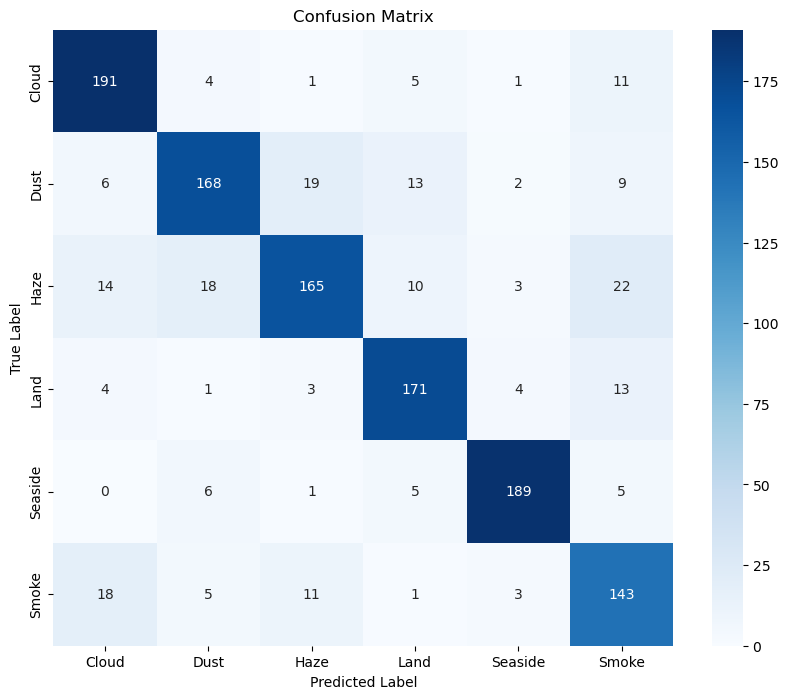

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = list(test.class_indices.keys())
confusion_matrix = confusion_matrix(pred, y_true)


plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [9]:
y_pred_proba = nasnet_mobile.predict(X_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

n_classes = len(class_labels)
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)


y_true_binary = label_binarize(y_true, classes = np.arange(n_classes))

metrics = ['Precision', 'Recall', 'F1-score', 'False Negative Rate', 'ROC-AUC']

df_metrics = pd.DataFrame(index=metrics, columns=class_labels)

for i in range(n_classes):
    df_metrics.iloc[0, i] = TP[i] / (TP[i] + FP[i])
    df_metrics.iloc[1, i] = TP[i] / (TP[i] + FN[i])
    df_metrics.iloc[2, i] = 2 * TP[i] / (2 * TP[i] + FP[i] + FN[i])
    df_metrics.iloc[3, i] = FN[i] / (FN[i] + TP[i])  # False Negative Rate
    df_metrics.iloc[4, i] = roc_auc_score(y_true_binary[:, i], y_pred_proba[:, i])
    
def round_fn(input): 
    return round(input, 4)

df_metrics = df_metrics.map(round_fn)
df_metrics

,Cloud,Dust,Haze,Land,Seaside,Smoke
Precision,0.8197,0.8317,0.8250,0.8341,0.9356,0.7044
Recall,0.8967,0.7742,0.7112,0.8724,0.9175,0.7901
F1-score,0.8565,0.8019,0.7639,0.8529,0.9265,0.7448
False Negative Rate,0.1033,0.2258,0.2888,0.1276,0.0825,0.2099
ROC-AUC,0.9783,0.9664,0.9597,0.9705,0.9931,0.9257


In [11]:
from sklearn.metrics import accuracy_score

print(f'Accuracy Score: {accuracy_score(pred, y_true):.4f}')
for index, row in df_metrics.iterrows(): 
    row_mean = row.mean()
    print(f'Average {index} Score: {row_mean:.4f}')

Accuracy Score: 0.8249
Average Precision Score: 0.8251
Average Recall Score: 0.8270
Average F1-score Score: 0.8244
Average False Negative Rate Score: 0.1730
Average ROC-AUC Score: 0.9656


In [12]:
feature_extractor = Model(inputs=nasnet_mobile.input, outputs=nasnet_mobile.get_layer('global_average_pooling2d').output)
feature_extractor_pred = feature_extractor.predict(X_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 396ms/step


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feature_extractor_pred = scaler.fit_transform(feature_extractor_pred)
feature_extractor_df = pd.DataFrame(feature_extractor_pred)
y_true_series = pd.Series(y_true)

class_mapping = dict()
for i, label in enumerate(class_labels): 
    class_mapping[i] = label

y_true_labels = y_true_series.map(class_mapping)

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state= 1, perplexity= 30, max_iter = 2000, learning_rate= 'auto', init = 'pca')
X_tsne = tsne.fit_transform(feature_extractor_df)
tsne_df = pd.DataFrame(data = {
    'x1': X_tsne[:, 0], 
    'x2': X_tsne[:, 1], 
    'class': y_true_series
})

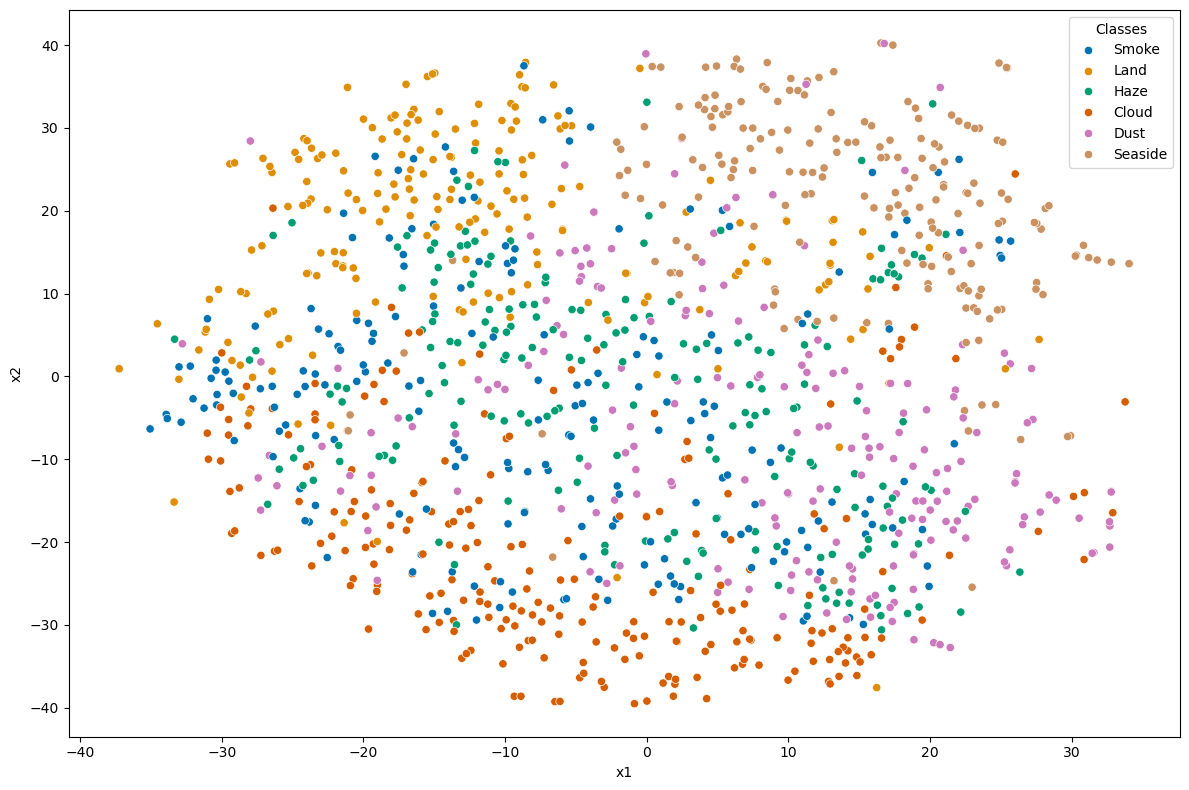

In [15]:
plt.figure(figsize= (12, 8))
scatter = sns.scatterplot(x = 'x1', y = 'x2', data = tsne_df, hue = y_true_labels, palette = 'colorblind')
scatter.legend(title = 'Classes')
plt.tight_layout()
plt.show()

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

features = tsne_df[['x1','x2']]
kmeans = KMeans(n_clusters=6, max_iter=1500, random_state=1)
kmeans.fit(features)

cluster_labels = kmeans.labels_

inertia = kmeans.inertia_
silhouette = silhouette_score(features, cluster_labels)
davies = davies_bouldin_score(features, cluster_labels)


print(f'Inertia: {inertia:,.3f}')
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Score: {davies:.3f}")

Inertia: 140,217.000
Silhouette Score: 0.395
Davies-Bouldin Score: 0.806
